<a href="https://colab.research.google.com/github/charlesphu/kaggleComp/blob/main/kaggle_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image
from torchvision.datasets import ImageFolder
from PIL import Image
import torchvision.transforms as T
from collections import Counter

In [ ]:
# Globals
BATCH_SIZE = 64
NUM_CLASSES = 50
CONF_THRESHOLD = 0.85
EPOCHS = 50
IMAGE_SIZE = 224
MODEL_SAVE_DIR = 'saved_models'

In [7]:
def build_colormap_from_all_masks(mask_dir):
    color_set = set()

    # Search all mask images
    for mask_path in glob.glob(os.path.join(mask_dir, "**", "*.*"), recursive=True):
        try:
            mask = Image.open(mask_path).convert("RGB")
            mask_np = np.array(mask)
            pixels = mask_np.reshape(-1, 3)
            unique_colors = np.unique(pixels, axis=0)
            for color in unique_colors:
                color_set.add(tuple(color))
        except Exception as e:
            print(f"Failed on {mask_path}: {e}")

    sorted_colors = sorted(color_set)
    colormap = {color: idx for idx, color in enumerate(sorted_colors)}
    print("Built COLORMAP with", len(colormap), "entries:", colormap)
    return colormap
# Define your colormap — customize this based on how your masks encode classes
COLORMAP = build_colormap_from_all_masks("train-semi-segmentation")

Built COLORMAP with 52 entries: {(np.uint8(0), np.uint8(0), np.uint8(0)): 0, (np.uint8(1), np.uint8(0), np.uint8(0)): 1, (np.uint8(2), np.uint8(0), np.uint8(0)): 2, (np.uint8(3), np.uint8(0), np.uint8(0)): 3, (np.uint8(4), np.uint8(0), np.uint8(0)): 4, (np.uint8(5), np.uint8(0), np.uint8(0)): 5, (np.uint8(6), np.uint8(0), np.uint8(0)): 6, (np.uint8(7), np.uint8(0), np.uint8(0)): 7, (np.uint8(8), np.uint8(0), np.uint8(0)): 8, (np.uint8(9), np.uint8(0), np.uint8(0)): 9, (np.uint8(10), np.uint8(0), np.uint8(0)): 10, (np.uint8(11), np.uint8(0), np.uint8(0)): 11, (np.uint8(12), np.uint8(0), np.uint8(0)): 12, (np.uint8(13), np.uint8(0), np.uint8(0)): 13, (np.uint8(14), np.uint8(0), np.uint8(0)): 14, (np.uint8(15), np.uint8(0), np.uint8(0)): 15, (np.uint8(16), np.uint8(0), np.uint8(0)): 16, (np.uint8(17), np.uint8(0), np.uint8(0)): 17, (np.uint8(18), np.uint8(0), np.uint8(0)): 18, (np.uint8(19), np.uint8(0), np.uint8(0)): 19, (np.uint8(20), np.uint8(0), np.uint8(0)): 20, (np.uint8(21), np.uin

torch.Size([16, 3, 128, 128])
torch.Size([16])
torch.Size([16, 128, 128])


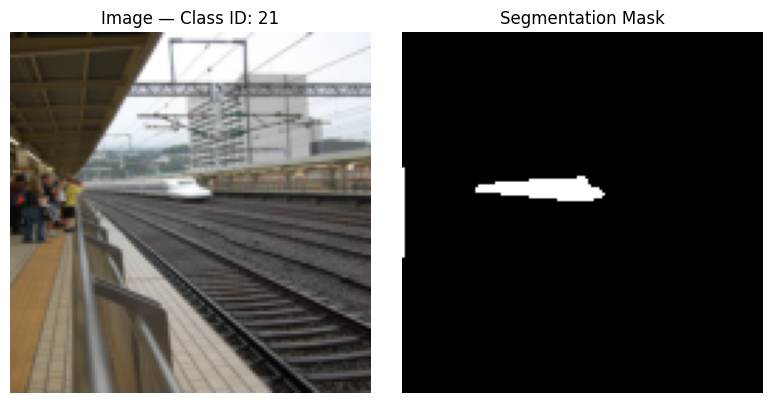

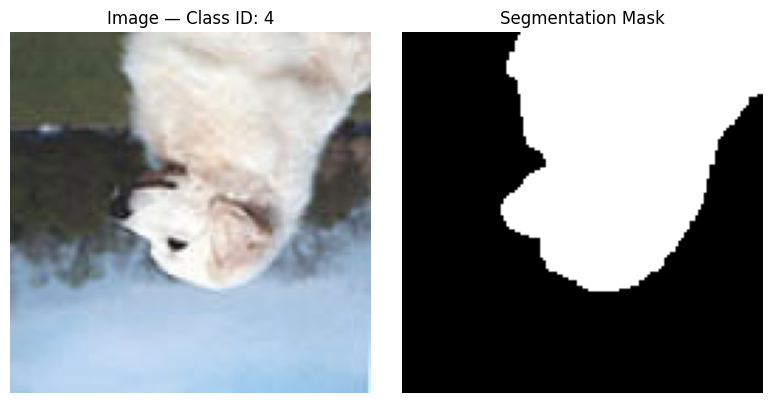

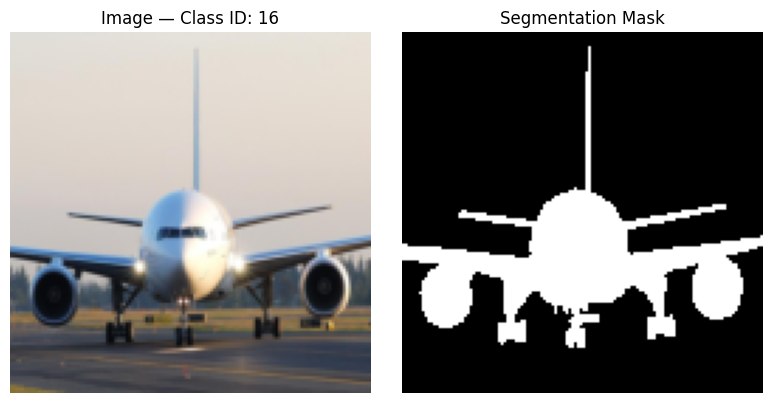

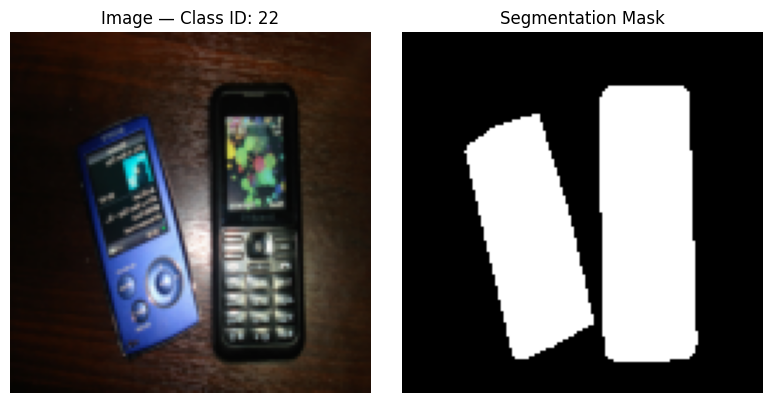

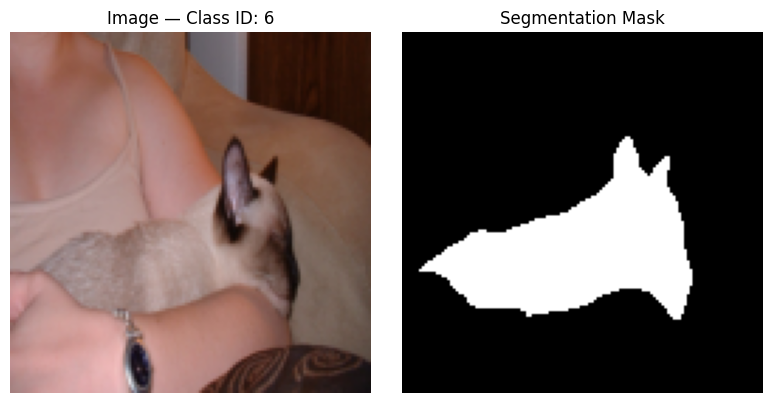

In [8]:
def rgb_to_class(mask_rgb):
    """Convert an RGB mask to a single-channel class mask."""
    mask_np = np.array(mask_rgb)
    class_mask = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.uint8)

    for rgb, class_id in COLORMAP.items():
        match = np.all(mask_np == rgb, axis=-1)
        class_mask[match] = class_id

    return class_mask

class ImageNetSubsetSegmentationDataset(Dataset):
    def __init__(self, json_path, colormap, image_size=(128, 128), mode='both', augment=False):
        self.image_dir = "train-semi"
        self.mask_dir = "train-semi-segmentation"
        self.mode = mode
        self.image_size = image_size
        self.colormap = colormap
        self.augment = augment

        with open(json_path, "r") as f:
            self.samples = json.load(f)

        self.to_tensor = T.ToTensor()
        self.resize_image = T.Resize(image_size)
        self.resize_mask = T.Resize(image_size, interpolation=Image.NEAREST)

    def __len__(self):
        return len(self.samples)

    def rgb_to_class(self, mask_rgb):
        mask_np = np.array(mask_rgb)
        h, w, _ = mask_np.shape
        class_mask = np.zeros((h, w), dtype=np.uint8)

        for rgb, class_id in self.colormap.items():
            match = np.all(mask_np == rgb, axis=-1)
            class_mask[match] = class_id

        return class_mask

    def apply_augmentations(self, image, mask):
        if random.random() < 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        if random.random() < 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        if random.random() < 0.5:
            angle = random.uniform(-15, 15)
            image = TF.rotate(image, angle, interpolation=T.InterpolationMode.BILINEAR)
            mask = TF.rotate(mask, angle, interpolation=T.InterpolationMode.NEAREST)
        return image, mask

    def __getitem__(self, idx):
        entry = self.samples[idx]
        image_rel = entry["image"]
        mask_rel = entry["mask"]
        class_id = entry["class_id"]

        # Image and mask paths
        image_path = os.path.join(self.image_dir, image_rel)
        mask_path = os.path.join(self.mask_dir, mask_rel)

        # Fallback if file extension mismatch
        if not os.path.exists(image_path):
            pattern = os.path.splitext(image_path)[0] + ".*"
            image_path = glob.glob(pattern)[0]
        if not os.path.exists(mask_path):
            pattern = os.path.splitext(mask_path)[0] + ".*"
            mask_path = glob.glob(pattern)[0]

        # Load PIL
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        # Resize
        image = self.resize_image(image)
        mask = self.resize_mask(mask)

        # Augment if needed
        if self.augment:
            image, mask = self.apply_augmentations(image, mask)

        # Final transforms
        image = self.to_tensor(image)
        mask = self.rgb_to_class(mask)
        mask = torch.from_numpy(mask).long()  # shape [H, W]

        if self.mode == "classification":
            return image, class_id
        elif self.mode == "segmentation":
            return image, mask
        elif self.mode == "both":
            return image, class_id, mask

# Plot function
def plot_segmentation(image, mask, class_id=None):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(to_pil_image(image))
    axs[0].set_title(f"Image" + (f" — Class ID: {class_id}" if class_id is not None else ""))
    axs[0].axis("off")

    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("Segmentation Mask")
    axs[1].axis("off")

    plt.tight_layout()
    plt.imshow(mask, cmap='gray')

# Load dataset
dataset = ImageNetSubsetSegmentationDataset(
    json_path="train_semi_annotations_with_seg_ids.json",
    mode='both',
    augment=True,
    colormap=COLORMAP,
)

# DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Inspect one batch
images, class_ids, masks = next(iter(dataloader))
print(images.shape)     # [16, 3, 128, 128]
print(class_ids.shape)  # [16]
print(masks.shape)      # [16, 128, 128]

for i in range(5):
    plot_segmentation(images[i], masks[i], class_ids[i])


In [9]:
# --- Attention Block ---
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

# --- Conv Block with Dropout + Attention ---
def conv_block(in_c, out_c, dropout=0.0):
    layers = [
        nn.Conv2d(in_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
    ]
    if dropout > 0:
        layers.append(nn.Dropout(dropout))
    layers.append(SEBlock(out_c))
    return nn.Sequential(*layers)

# --- Full UNet Model ---
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=NUM_CLASSES):
        super(UNet, self).__init__()

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec3 = conv_block(1024, 512, dropout=0.3)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = conv_block(512, 256, dropout=0.2)

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = conv_block(256, 128, dropout=0.1)

        self.up0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec0 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d3 = self.up3(b)
        d3 = torch.cat([d3, e4], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)

        d0 = self.up0(d1)
        d0 = torch.cat([d0, e1], dim=1)
        d0 = self.dec0(d0)

        out = self.final(d0)
        return F.softmax(out, dim=1)


In [10]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = F.softmax(preds, dim=1)
        preds_flat = preds.view(preds.size(0), preds.size(1), -1)
        targets_flat = F.one_hot(targets, preds.size(1)).permute(0, 3, 1, 2).reshape_as(preds_flat)

        intersection = (preds_flat * targets_flat).sum(2)
        union = preds_flat.sum(2) + targets_flat.sum(2)

        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice_score.mean()

# Combined loss
def combined_loss(preds, targets):
    ce = nn.CrossEntropyLoss()(preds, targets)
    dice = DiceLoss()(preds, targets)
    return ce + dice


In [11]:
def dice_score(preds, targets, smooth=1.0):
    preds = torch.argmax(preds, dim=1)
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat == targets_flat).float().sum()
    total = preds_flat.numel() + targets_flat.numel()
    return (2.0 * intersection + smooth) / (total + smooth)

def iou_score(preds, targets, smooth=1.0):
    preds = torch.argmax(preds, dim=1)
    intersection = ((preds == targets) & (targets > 0)).float().sum()
    union = ((preds > 0) | (targets > 0)).float().sum()
    return (intersection + smooth) / (union + smooth)

def validate(model, val_loader, device):
    model.eval()
    total_dice, total_iou, total_loss = 0, 0, 0

    with torch.no_grad():
        for images, class_id, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            total_loss += combined_loss(outputs, masks).item()
            total_dice += dice_score(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()

    n = len(val_loader)
    print(f"[Validation] Loss: {total_loss/n:.4f} | Dice: {total_dice/n:.4f} | IoU: {total_iou/n:.4f}")
    return total_loss/n, total_dice/n, total_iou/n


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)
model = UNet(in_channels=3, out_channels=52).to(device)
# model = SimpleUNet(232 + 1).to(device)
criterion = nn.CrossEntropyLoss()  # expects (B, C, H, W) logits and (B, H, W) target
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

using cuda


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, class_id, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    validate(model, dataloader, device)




Epoch [1/10], Train Loss: 4.9424
[Validation] Loss: 4.9399 | Dice: 0.4146 | IoU: 0.0056
Epoch [2/10], Train Loss: 4.9245
[Validation] Loss: 4.8708 | Dice: 0.1757 | IoU: 0.0117


In [ ]:
def visualize_prediction(model, data_loader, device, num_samples=3):
    model.eval() # Set the model to evaluation mode

    visualized_count = 0 # Counter for how many images we have visualized

    with torch.no_grad(): # Disable gradient calculations for inference
        for batch_idx, (images, class_id, masks) in enumerate(data_loader):
            images = images.float().to(device)

            # Perform prediction
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1) # Assuming standard segmentation output

            # Iterate through images in the current batch
            for i in range(images.shape[0]): # images.shape[0] is the batch size
                if visualized_count >= num_samples:
                    print(f"Visualized {num_samples} images. Stopping.")
                    return # Stop if we've reached the desired number of samples

                plt.figure(figsize=(20, 5)) # Increased figsize for 4 subplots

                # Input Image
                plt.subplot(1, 5, 1)
                display_image_np = images[i].permute(1, 2, 0).cpu().numpy()
                display_image_np = (display_image_np * 255).astype(np.uint8)
                plt.imshow(display_image_np)
                plt.title("Input Image")
                plt.axis('off') # Optional: remove axes for cleaner image display

                # Ground Truth Mask
                plt.subplot(1, 5, 2)
                plt.imshow(masks[i].cpu(), cmap="gray")
                plt.title("Ground Truth")
                plt.axis('off')

                # Prediction with inferno colormap
                plt.subplot(1, 5, 3)
                # Ensure preds[i] is on CPU and correct type if needed (e.g., float or int)
                # For classification predictions, cmap typically expects 0-255 or 0-1 range.
                # If preds are class IDs, they are typically integers.
                plt.imshow(preds[i].cpu().squeeze(), cmap="inferno") # .squeeze() for single-channel
                plt.title("Prediction (inferno)")
                plt.axis('off')

                # Prediction with jet colormap (for comparison)
                plt.subplot(1, 5, 4)
                plt.imshow(preds[i].cpu().squeeze(), cmap="jet") # .squeeze() for single-channel
                plt.title("Prediction (jet)")
                plt.axis('off')

                # Prediction with gray colormap (for comparison)
                plt.subplot(1, 5, 5)
                plt.imshow(preds[i].cpu().squeeze(), cmap="gray") # .squeeze() for single-channel
                plt.title("Prediction (gray)")
                plt.axis('off')

                plt.tight_layout() # Adjust layout to prevent overlap
                plt.show()

                visualized_count += 1

    print(f"Finished visualizing {visualized_count} images from the data loader.")
visualize_prediction(model, dataloader, device, num_samples=5)

In [ ]:
from datetime import datetime
def save_model_with_timestamp(model, save_dir="models", model_name="my_model"):
    """
    Saves a PyTorch model to a specified directory with a timestamp in its filename.

    Args:
        model (torch.nn.Module): The PyTorch model to save.
        save_dir (str): The directory where the model should be saved.
                        Defaults to "models".
        model_name (str): The base name for the model file.
                          Defaults to "my_model".
    """
    # 1. Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # 2. Generate a timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S") # Format: YYYYMMDD_HHMMSS

    # 3. Create the full filename with path
    filename = f"{model_name}.pth" # Using .pth or .pt extension
    filepath = os.path.join(save_dir, filename)

    # 4. Save the model
    torch.save(model, filepath)
    print(f"Model saved successfully to: {filepath}")

save_model_with_timestamp(model, save_dir="saved_models", model_name="unetv3")